# DQN改进算法
## 简介
DQN算法敲开了深度强化学习的大门，但是作为先驱性的工作，其本身也存在着一些问题以及一些可以改进的地方，于是在DQN之后学术界涌现出了非常多的改进算法。在本节课程中，我们将介绍其中两个非常著名的算法：Double DQN和Dueling DQN，这两个算法实现非常简单，只需要在DQN上进行略微修改，但能一定程度改善DQN的效果。如果想要了解更加详细的各种DQN改进方法，我们推荐读者阅读论文Rainbow以及其中的引用文献。

## Double DQN

普通的DQN算法通常会导致对$Q$值的过高估计。我们可以观察到，传统DQN优化的TD目标为
$$
r+\gamma \max _{a'} Q_{\omega^-}\left(s', a' \right)
$$
其中$\max _{a'} Q_{\omega^-}\left(s', a' \right)$由目标网络（参数为$\omega^-$）计算得出，我们还可以将其写成如下形式

$$
Q_{\omega^-}\left(s', \arg\max_{a'} Q_{\omega^-}\left(s',  a' \right) \right)
$$

换句话说，max操作实际可以被拆解为两部分，首先选取状态$s'$下的最优动作$a^{*} = \underset{a'}{\operatorname{argmax}} Q_{\omega^-}\left(s', a' \right)$，接着计算该动作对应的价值$Q\left(s', a^* \right)$。
当这两部分采用同一套$Q$网络进行计算时，每次得到的都是神经网络当前估算的所有动作价值中的最大值。考虑到我们通过神经网络估算的$Q$值本身在某些时候会产生或正或负的误差，在DQN的更新方式下神经网络会将正误差累积。比如我们考虑一个特殊情形，在状态$s'$下所有动作的$Q$值均为0，即$Q(s', a_i)=0,\forall i$，此时正确的更新目标应为$r+0=r$。但是由于神经网络拟合的误差通常会出现某些动作的估算有正误差，即存在$Q(s', a_j) > 0$，此时我们的更新目标出现了过高估计，$r+\gamma \max Q > r+0$。所以当我们用DQN的更新公式进行更新时，$Q(s, a)$也就会被过高估计了。同理，我们拿这个$Q(s,a)$来作为更新目标来更新上一步的$Q$值时，同样会过高估计，并且误差将会逐步累积。


为了解决这一问题，Double DQN算法提出利用两个独立训练的神经网络估算$\max_{a'} Q_*(s', a')$。具体做法是将原有的$\max _{a'} Q_{\omega^-}\left(s', a'\right)$更改为

$$
Q_{\omega^-}\left(s', \arg\max_{a'} Q_{\omega}\left(s',  a' \right) \right)
$$

即我们利用一套神经网络$Q_{\boldsymbol{\omega}}$的输出选取价值最大的动作，然而在使用该动作的价值时，用另一套神经网络$Q_{\boldsymbol{\omega}^{-}}$计算该动作的价值。这样，就算其中一套神经网络某个动作存在比较严重的过高估计，由于另一套神经网络的存在，这个动作最终使用的$Q$值不会存在很大的过高估计，从一定程度上解决了这个问题。

而我们注意到，在传统的DQN算法中，本来就存在两套$Q$函数的神经网络——目标网络和训练网络，只不过$\max_{a'} Q_{\omega^-}\left(s', a' \right)$的计算只用到了其中的目标网络，那么我们恰好可以直接将训练网络作为Double DQN算法中的第一套神经网络选取动作，将目标网络作为第二套神经网络计算Q值，这便是Double DQN的主要思想。由于在DQN算法中我们就将训练网络的参数记为$\omega$，将目标网络的参数记为$\omega^{-}$，这与之前Double DQN中写下的两套神经网络的参数是统一的，我们可以直接写出如下Double DQN的优化目标

$$
r+\gamma Q_{\omega^-}\left(s', \arg\max_{a'} Q_\omega\left(s', a'\right)\right)
$$

<img src="https://staticcdn.boyuai.com/user-assets/358/K3gRHxosX5FugJc2dAwxHL/qipg4vdji5.png!png" width = "900" height = "900" align=center />
 
<center>Double DQN和DQN对比图</center>


## Double DQN代码实践
显然，Double DQN与DQN的差别只是在于计算状态$s'$下$Q$值时动作的选取上：
* DQN的优化目标可以写为$r+\gamma Q_{\omega^-}\left(s', \arg\max_{a'} Q_{\omega^-}\left(s', a'\right)\right)$，动作的选取依靠目标网络$Q_{\omega^-}$
* Double DQN的优化目标为$r+\gamma Q_{\omega^-}\left(s', \arg\max_{a'} Q_\omega\left(s', a' \right)\right)$，动作的选取依靠训练网络$Q_\omega$

所以代码实现可以直接在原DQN的基础上进行，无需做过多修改。

本次采用的环境是[Pendulum](https://gym.openai.com/envs/Pendulum-v0/)，该环境下有一个从随机位置开始的钟摆，钟摆向上保持直立时奖励为0，钟摆在其他位置时奖励为负数，环境本身没有终止状态。环境的状态为钟摆角度的正弦值$\sin \theta$，余弦值$\cos \theta$，角速度$\dot\theta$，动作为对钟摆施加的力矩。每一步会根据当前摆的状态的好坏给予不同的奖励。200步后自动结束游戏。

该环境的状态有三个参数：

标号 | 名称  | 最小值 | 最大值  
----|--------------|-----|----   
0   | $\cos \theta$  | -1.0| 1.0
1   | $\sin \theta$  | -1.0| 1.0
2   | $\dot \theta$  | -8.0| 8.0

该环境只有一类动作（连续动作）：

标号 | 动作  | 最小值 | 最大值  
----|--------------|-----|----   
0   | 力矩 | -2.0| 2.0


<img src="https://staticcdn.boyuai.com/user-assets/358/ksRQPrDqHFAKjynictbYiG/pendulum.gif" width = "300" height = "300" align=center />
 
<center>Pendulum环境示意图</center>

**由于Pendulum-v0环境的动作是力矩大小，是在[-2,2]范围内的连续值。我么之前提到过，DQN只能处理离散动作环境，无法直接来解决Pendulum环境。但该环境可以比较方便我们来验证DQN对$Q$值的过高估计：该环境下$Q$值的最大估计应为0(钟摆向上保持竖直时能选取的最大$Q$值)，$Q$值出现大于0的情况则说明出现了过高估计。为了能够应用DQN，我们采用离散化动作的技巧。如下面的代码中我们将连续的动作空间离散为11个动作。动作[0，1，..., 9, 10]分别代表力矩为[-2, -1.6, -1.4， ..., 1.4, 1.6, 2]**。



In [1]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm

In [2]:
class Qnet(torch.nn.Module):
    ''' 一层隐层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class DQN:
    ''' DQN算法，包括DoubleDQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim 
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) 
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) 
        self.optimizer= torch.optim.Adam(self.q_net.parameters(), lr=learning_rate) 
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.target_update = target_update 
        self.count = 0
        self.dqn_type = dqn_type
    
    def take_action(self, state): 
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float)
        actions =  torch.tensor(transition_dict['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)

        q_values = self.q_net(states).gather(1, actions) 
        if self.dqn_type == 'DoubleDQN': # Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) 
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) 
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward() 
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [7]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作

def dis_to_con(discrete_action, env, action_dim): # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0] # 连续动作的最小值
    action_upbound = env.action_space.high[0] # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

In [8]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995 # 平滑处理
                    max_q_value_list.append(max_q_value) # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 9: 100%|███████████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s, episode=200, return=-211.823]


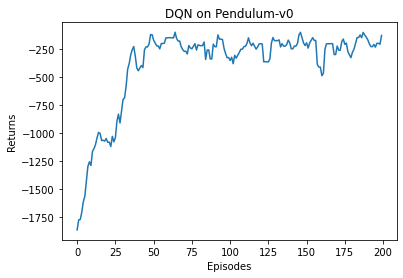

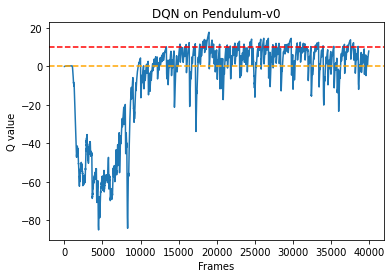

In [9]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('DQN on {}'.format(env_name))  
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')   
plt.ylabel('Q value')  
plt.title('DQN on {}'.format(env_name))  
plt.show()

根据实验结果我们发现，DQN算法在Pendulum环境上能取得不错的回报，最后的平均回报在-200左右，但是Q值可视化之后发现不少超过了0，并且有一些还超过了10，该现象便是DQN算法中的Q值过高估计。我们现在看一下Double DQN是否能对此进行改善。

In [15]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('Double DQN on {}'.format(env_name))  
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')   
plt.ylabel('Q value')  
plt.title('Double DQN on {}'.format(env_name))  
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s, episode=200, return=-285.691]


<Figure size 432x288 with 1 Axes>

<Figure size 432x288 with 1 Axes>

我们可以发现，相比于普通的DQN，Double DQN算法比较少出现Q值大于0的情况，说明Q值过高估计的问题得到了很大缓解。

## Dueling DQN

[Dueling DQN](https://arxiv.org/abs/1511.06581)是另一种DQN的改进算法。它在传统DQN的基础上只进行了稍稍改动，但却能大幅提升DQN的表现。在强化学习中，我们将状态动作价值函数减去状态函数定义为优势函数，即$A(s,a) = Q(s,a)-V(s)$。在同一个状态下，所有动作的优势值之和为0，因为所有动作的动作价值的平均就是这个状态的状态价值。据此，在Dueling DQN中，Q网络被建模为：

$$
Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a)
$$

其中$V_{\eta, \alpha}(s)$为状态价值函数，而$A_{\eta, \beta}(s, a )$则为该状态下采取不同动作的优势函数，表征的是采取不同动作的差异性。$\eta$是状态价值函数和优势函数共享的网络参数，一般为神经网络用来提取特征的前几层。而$\alpha$和$\beta$为两者各自的参数。在这样的建模下我们不再让神经网络直接输出$Q$值，而是训练神经网络的两部分分别输出价值函数和优势函数，再求和得到$Q$值。DQN和Dueling DQN的网络结构图区别如下：

<img src="https://staticcdn.boyuai.com/user-assets/358/XRT3k5AYGLF233uvCsmTN4/qfmiegdc53.png!png" width = "300" height = "300" align=center />
 
<center>DQN与Dueling DQN网络结构的区别</center>

将状态价值函数和优势函数分别建模的好处在于某些情境下智能体只会关注状态的价值，而并不关心不同动作导致的差异，此时将二者分开建模能够使智能体更好地处理与动作关联较小的状态。如下图的驾驶车辆游戏中，智能体注意力集中的部位被显示为偏橙色，在智能体前面没有车时，车子自身动作并没有太大差异，此时智能体更关注于状态价值，而在有车时（智能体需要超车），智能体开始关注不同动作优势值上的差异。

<img src="https://staticcdn.boyuai.com/user-assets/358/hvt243eeywugHYf6AEdiNG/qwdfh8aa3t.png!png" width = "300" height = "300" align=center />
 
<center>状态价值和优势值的简单例子</center>

对于上述Dueling DQN中的公式$Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a)$，它存在对于$A$值和$V$值建模不唯一性的问题（比如对于同样的$Q$值，如果将$V$值加上任意大小的常数$C$，再将所有$A$值减去$C$，则我们得到的$Q$值依然不变，这就给训练造成了不稳定）。为了解决这一问题，Dueling DQN强制最优动作的优势函数的实际输出为$0$，即
$$
Q_{\eta, \alpha, \beta}(s, a )=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a )-\max _{a^{\prime}} A_{\eta, \beta}\left(s, a^{\prime}\right)
$$
此时$V(s) = \max_a Q(s,a)$，可以确保$V$值建模的唯一性。
在实际实现过程中，我们还可以用平均代替最大化操作，即
$$
Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+ A_{\eta, \beta}(s, a)-\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} A_{\eta, \beta}\left(s, a^{\prime}\right)
$$
此时$V(s) = \frac{1}{|\mathcal{A}|} \sum_{a^{\prime}}Q(s,a')$。在下面的代码实现中，我们将采取此种方式，虽然它不再满足最优策略的贝尔曼方程，但实际应用时更加稳定。

有人可能能会问：为什么Dueling DQN会比DQN好？原论文里写道Dueling DQN能更高效学习状态价值函数。每一次更新时，$V$函数都会被更新到，这也会影响到其他动作的$Q$值；而传统的DQN只会更新某个动作的$Q$值，其他动作的$Q$值就不会更新。这样能够更加频繁准确的学习到状态价值函数。

## Dueling DQN代码实践
Dueling DQN与DQN相比的差异只是在网络结构上，大部分代码依然可以继续沿用。

In [16]:
class VAnet(torch.nn.Module):
    ''' 一层隐层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1) # Q值由V值和A值计算得到
        return Q

In [17]:
class DQN:
    ''' DQN算法，包括Double DQN和Dueling DQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim 
        if dqn_type == 'DuelingDQN': # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device) 
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) 
            self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) 
        self.optimizer= torch.optim.Adam(self.q_net.parameters(), lr=learning_rate) 
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.target_update = target_update 
        self.count = 0
        self.dqn_type = dqn_type
    
    def take_action(self, state): 
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float)
        actions =  torch.tensor(transition_dict['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)

        q_values = self.q_net(states).gather(1, actions) 
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) 
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) 
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward() 
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [18]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('Dueling DQN on {}'.format(env_name))  
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')   
plt.ylabel('Q value')  
plt.title('Dueling DQN on {}'.format(env_name))  
plt.show()

Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s, episode=200, return=-192.522]


<Figure size 432x288 with 1 Axes>

<Figure size 432x288 with 1 Axes>

由曲线可知，相比于传统的DQN，Dueling DQN相比于DQN在多个动作选择下的学习更加稳定，并且得到的回报最大值也更大。由Dueling DQN的原理可知随着动作空间的增大，Dueling DQN相比于DQN的优势更为明显。之前我们在环境中设置的离散动作为11个，如果将离散动作数增多（15， 25， ...），我们可以继续进行对比实验。

## 总结
在传统的DQN基础上，有两种非常容易实现的变式——Double DQN和Dueling DQN，Double DQN解决了DQN中对Q值的过高估计，而Dueling DQN能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。

## 扩展阅读： 对Q值过高估计的定量分析
我们可以对Q值的过估计做一个简化的定量分析。假设在状态$s$下所有动作的期望回报均无差异，即$Q_*(s,a) = V_*(s)$（此情形是为了定量分析所简化的情形，实际上不同动作的期望回报通常会存在差异）。假设神经网络估算误差$Q_{\omega^-}(s, a)-V_{*}$服从$[-1,1]$之间的均匀独立同分布。假设动作空间大小为$m$，那么对于任意状态$s$我们有
$$
\mathbb{E}\left[\max _{a} Q_{\omega^-}(s, a)- \max_{a'} Q_{*}(s,a')\right]=\frac{m-1}{m+1}
$$
**证明：**
我们将估算误差记为$\epsilon_{a}=Q_{\omega^-}(s, a)-\max_{a'}Q_{*}(s, a')$，由于估算误差对于不同的动作是独立的，我们有
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) =\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right)
\end{aligned}
$$
$P(\epsilon_a \leq x)$是$\epsilon_a$的累积分布函数（CDF）,它可以具体被写为
$$
P\left(\epsilon_{a} \leq x\right)=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\frac{1+x}{2} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
$$
因此，我们有关于$\max_a \epsilon_a$的累积密度函数(CDF)
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) &=\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right) \\
&=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\left(\frac{1+x}{2}\right)^{m} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
\end{aligned}
$$
最后我们可以得到
$$
\begin{aligned}
\mathbb{E}\left[\max _{a} \epsilon_{a}\right] &=\int_{-1}^{1} x \frac{\mathrm{d}}{\mathrm{d} x} P\left(\max _{a} \epsilon_{a} \leq x \right) \mathrm{d} x \\
&=\left[\left(\frac{x+1}{2}\right)^{m} \frac{m x-1}{m+1}\right]_{-1}^{1} \\
&=\frac{m-1}{m+1}
\end{aligned}
$$
虽然这一分析简化了实际环境，但它正确刻画了Q值过高估计的一些性质，比如Q值的过高估计随动作数目$m$的增加而增加，换而言之，在动作选择数更多的环境中Q值的过高估计会更严重。